In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_openml, load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler

from tqdm.auto import tqdm

In [ ]:
def compute_unweighted_knn_class_shapley(
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_valid: np.ndarray,
    y_valid: np.ndarray,
    K: int) -> np.ndarray:

    dist_idx_matrix = np.argsort(pairwise_distances(X=X_valid, Y=X_train, metric='cosine', n_jobs=-1), axis=1)

    N_train = X_train.shape[0]
    N_valid = X_valid.shape[0]
    sp_gt = np.zeros((N_valid, N_train))

    for j in tqdm(range(N_valid)):
        a_N = dist_idx_matrix[j, -1]
        sp_gt[j, a_N] = (y_train[a_N] == y_valid[j]) / N_train

        for i in np.arange(N_train - 2, -1, -1):
            a_i = dist_idx_matrix[j, i]
            a_ip1 = dist_idx_matrix[j, i + 1]
            sp_gt[j, a_i] = sp_gt[j, a_ip1]
            sp_gt[j, a_i] += (int(y_train[a_i] == y_valid[j]) - int(y_train[a_ip1] == y_valid[j])) / K * min([K, i + 1]) / (i + 1)

    return sp_gt

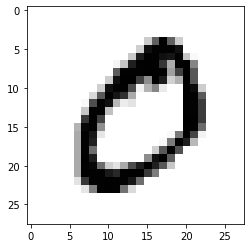

In [ ]:
X, y = fetch_openml(name="mnist_784", version=1, return_X_y=True, as_frame=False)

plt.imshow(X[1].reshape(28, -1), cmap=plt.cm.gray_r, interpolation="nearest")
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=10_000, test_size=1_000, shuffle=True, stratify=y, random_state=3407)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=5_000, test_size=5_000, shuffle=True, stratify=y_train, random_state=3407)

print(X_train.shape, X_valid.shape, X_test.shape)

(5000, 784) (5000, 784) (1000, 784)


In [ ]:
# X, y = load_digits(return_X_y=True)

# plt.imshow(X[1].reshape(8, -1), cmap=plt.cm.gray_r, interpolation="nearest")

# plt.show()

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True, stratify=y, random_state=42)
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.75, shuffle=True, stratify=y_train, random_state=42)

# scaler = StandardScaler()

# scaled_X_train = scaler.fit_transform(X_train)
# scaled_X_valid = scaler.transform(X_valid)
# scaled_X_test = scaler.transform(X_test)

# print(X_train.shape, X_valid.shape, X_test.shape)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_neighbors=10, metric='cosine')
knn_clf.fit(X=X_train, y=y_train)

KNeighborsClassifier(metric='cosine', n_neighbors=10)

In [ ]:
y_pred = knn_clf.predict(X_valid)
y_pred_proba = knn_clf.predict_proba(X_valid)

print(knn_clf.score(X_valid, y_valid))

0.9402


In [ ]:
misclf_idx = np.argwhere(y_pred != y_valid).flatten()

misclf_idx[1], y_valid[misclf_idx[1]], y_pred[misclf_idx[1]], y_pred_proba[misclf_idx[1]]

(2, '9', '7', array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.7, 0. , 0.3]))

In [ ]:
sv_matrix = compute_unweighted_knn_class_shapley(
    X_train=X_train,
    y_train=y_train,
    X_valid=X_valid,
    y_valid=y_valid,
    K=10
)

  0%|          | 0/5000 [00:00<?, ?it/s]

9


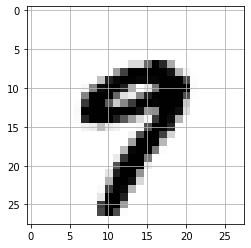

In [ ]:
valid_idx = misclf_idx[1]
print(y_valid[valid_idx])

plt.imshow(X_valid[valid_idx].reshape(28, -1), cmap=plt.cm.gray_r, interpolation="nearest")
plt.grid(True)
plt.show()

In [ ]:
pd.Series(sv_matrix[valid_idx]).groupby(y_train).mean() * 100

0   -0.001951
1   -0.001781
2   -0.000939
3   -0.001853
4   -0.017545
5   -0.002521
6   -0.000813
7   -0.193654
8   -0.006324
9    0.296690
dtype: float64

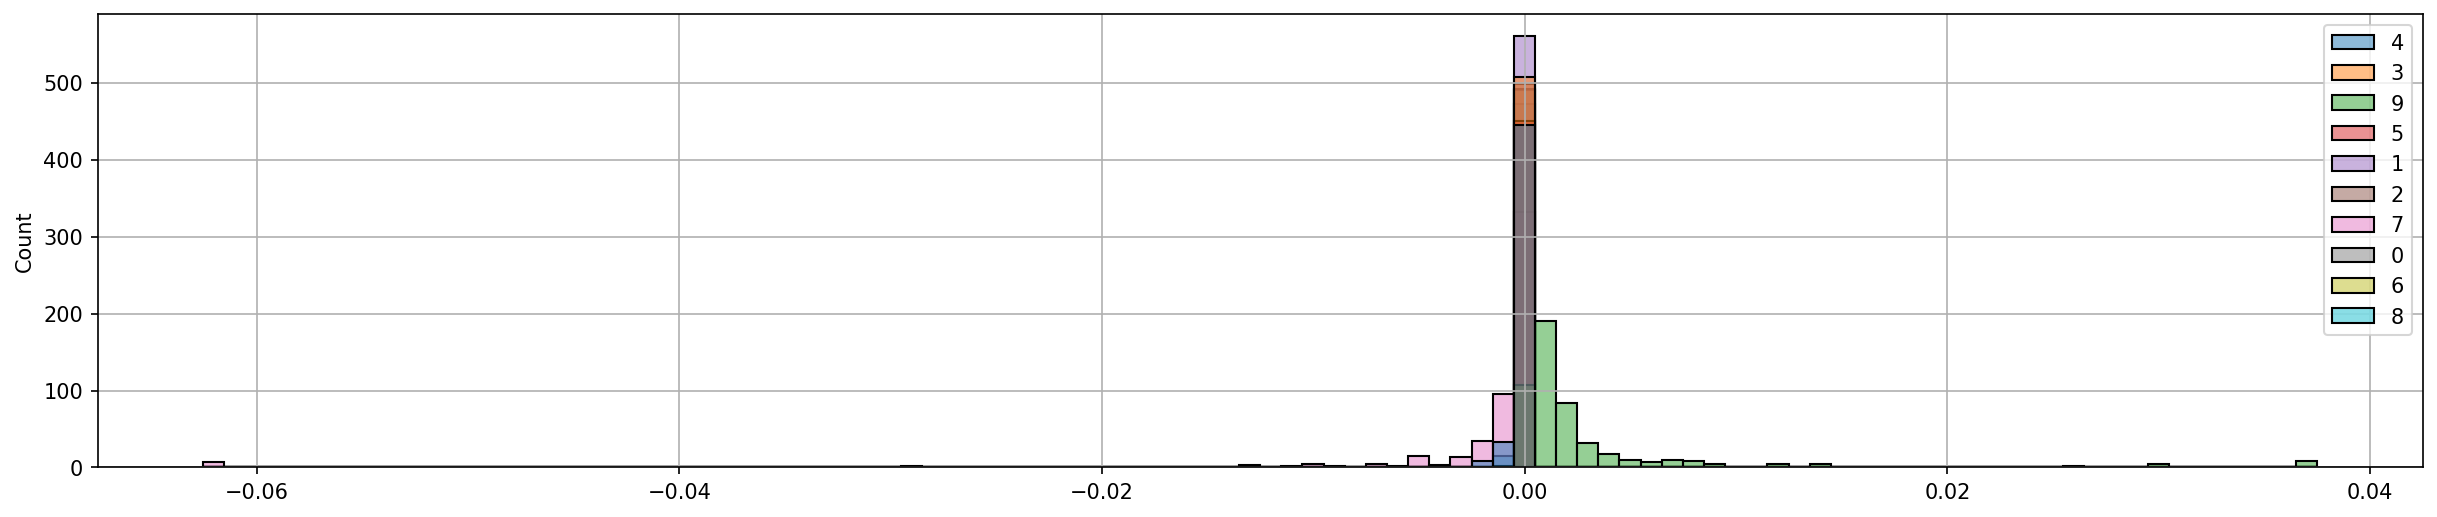

In [ ]:
plt.figure(figsize=(20, 4), dpi=150)
sns.histplot(x=sv_matrix[valid_idx], hue=y_train, bins=100)
plt.grid(True)
plt.show()

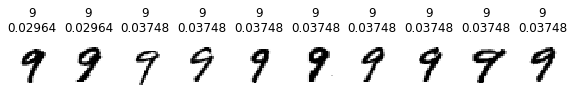

In [ ]:
k = 10

top_k = np.argpartition(sv_matrix[valid_idx], -k)[-k:]

fig, axes = plt.subplots(1, k, figsize=(k, 4))

for ax, train_idx in zip(axes, top_k):
    sv = sv_matrix[valid_idx, train_idx]
    ax.set_title(f'{y_train[train_idx]}\n{sv:.5f}')
    ax.set_axis_off()
    ax.imshow(X_train[train_idx].reshape(28, -1), cmap=plt.cm.gray_r, interpolation="nearest")
plt.show()

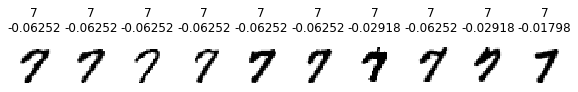

In [ ]:
bottom_k = np.argpartition(sv_matrix[valid_idx], k)[: k]

fig, axes = plt.subplots(1, k, figsize=(k, 4))

for ax, train_idx in zip(axes, bottom_k):
    sv = sv_matrix[valid_idx, train_idx]
    ax.set_title(f'{y_train[train_idx]}\n{sv:.5f}')
    ax.set_axis_off()
    ax.imshow(X_train[train_idx].reshape(28, -1), cmap=plt.cm.gray_r, interpolation="nearest")
plt.show()

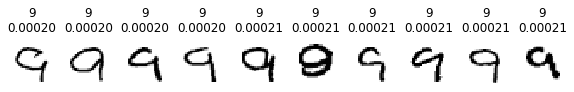

In [ ]:
bottom_k = np.argpartition(sv_matrix[valid_idx, y_train==y_valid[valid_idx]], k)[: k]

fig, axes = plt.subplots(1, k, figsize=(k, 4))

for ax, train_idx in zip(axes, bottom_k):
    sv = sv_matrix[valid_idx, y_train==y_valid[valid_idx]][train_idx]
    ax.set_title(f'{y_train[y_train==y_valid[valid_idx]][train_idx]}\n{sv:.5f}')
    ax.set_axis_off()
    ax.imshow(X_train[y_train==y_valid[valid_idx]][train_idx].reshape(28, -1), cmap=plt.cm.gray_r, interpolation="nearest")
plt.show()

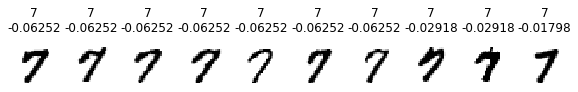

In [ ]:
bottom_k = np.argpartition(sv_matrix[valid_idx, y_train==y_pred[valid_idx]], k)[: k]

fig, axes = plt.subplots(1, k, figsize=(k, 4))

for ax, train_idx in zip(axes, bottom_k):
    sv = sv_matrix[valid_idx, y_train==y_pred[valid_idx]][train_idx]
    ax.set_title(f'{y_train[y_train==y_pred[valid_idx]][train_idx]}\n{sv:.5f}')
    ax.set_axis_off()
    ax.imshow(X_train[y_train==y_pred[valid_idx]][train_idx].reshape(28, -1), cmap=plt.cm.gray_r, interpolation="nearest")
plt.show()

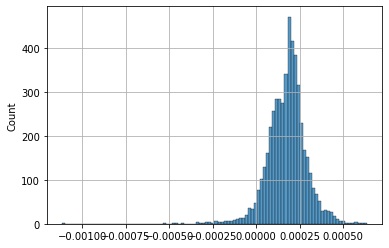

In [ ]:
data_shap = np.mean(sv_matrix, axis=0)

sns.histplot(x=data_shap, bins=100)
plt.grid(True)
plt.show()

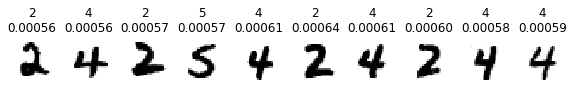

In [ ]:
top_k = np.argpartition(data_shap, -k)[-k: ]

fig, axes = plt.subplots(1, k, figsize=(k, 4))

for ax, train_idx in zip(axes, top_k):
    sv = data_shap[train_idx]
    ax.set_title(f'{y_train[train_idx]}\n{sv:.5f}')
    ax.set_axis_off()
    ax.imshow(X_train[train_idx].reshape(28, -1), cmap=plt.cm.gray_r, interpolation="nearest")
plt.show()

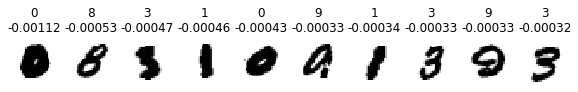

In [ ]:
bottom_k = np.argpartition(data_shap, k)[: k]

fig, axes = plt.subplots(1, k, figsize=(k, 4))

for ax, train_idx in zip(axes, bottom_k):
    sv = data_shap[train_idx]
    ax.set_title(f'{y_train[train_idx]}\n{sv:.5f}')
    ax.set_axis_off()
    ax.imshow(X_train[train_idx].reshape(28, -1), cmap=plt.cm.gray_r, interpolation="nearest")
plt.show()

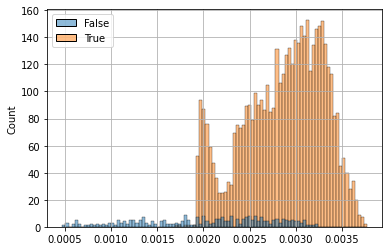

In [ ]:
sns.histplot(
    x=np.max(pd.DataFrame(sv_matrix.T).groupby(y_train).mean().T, axis=1),
    hue=(y_pred == y_valid),
    bins=100)
plt.grid(True)
plt.show()

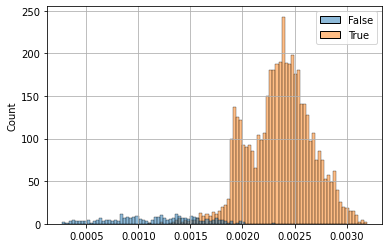

In [ ]:
sns.histplot(
    x=np.max(pd.DataFrame(sv_matrix.T).groupby(y_train).mean().T, axis=1) + np.min(pd.DataFrame(sv_matrix.T).groupby(y_train).mean().T, axis=1),
    hue=(y_pred == y_valid),
    bins=100
    )
plt.grid(True)
plt.show()

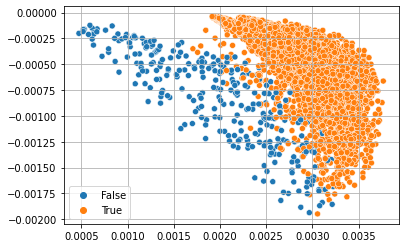

In [ ]:
sns.scatterplot(
    x=np.max(pd.DataFrame(sv_matrix.T).groupby(y_train).mean().T, axis=1),
    y=np.min(pd.DataFrame(sv_matrix.T).groupby(y_train).mean().T, axis=1),
    hue=(y_pred == y_valid)
    )
plt.grid(True)
plt.show()